# Regularized Linear Model
## Javier Palomares
### Question 2   
Follow the data preprocessing steps from https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models. Then run a ridge regression using $\alpha = 0.1$. Make a submission of this prediction, what is the RMSE you get?
(Hint: remember to exponentiate np.expm1(ypred) your predictions).


#### Preprocessing

In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [135]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

In [136]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [137]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

Data preprocessing:
We're not going to do anything fancy here:

* First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal
* Create Dummy variables for the categorical features
* Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a99838710>,
      dtype=object)

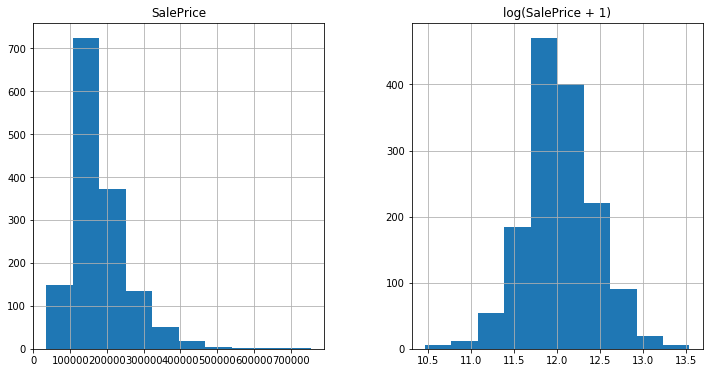

In [138]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"SalePrice":train["SalePrice"], "log(SalePrice + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [139]:
# log transform the sale price
train["SalePrice"] = np.log1p(train["SalePrice"])

# get the numberical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# compute the skeweness factor of features
# take features with factor greater than .75
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

# take the log of all skewed features
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [140]:
# Convert categorical variable into dummy/indicator variables
all_data = pd.get_dummies(all_data)

In [141]:
# filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [142]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

#### Models
Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [201]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso,LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [212]:
# function to compute the root mean squared error of the cross validation
def rmse_cv(model,X_train,y):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


We'll run a ridge regression using a value of $\alpha=0.1$

In [145]:
alpha = .1
ridge_model = Ridge(alpha=alpha)

In [216]:
cv_rmse_ridge = rmse_cv(ridge_model,X_train,y).mean()
print("Cross validation rmse using Ridge Regression = {}".format(cv_rmse_ridge))

Cross validation rmse using Ridge Regression = 0.13777538277187826


The ridge model gives a cross validation rmse of .1377 when $\alpha=.1$

In [148]:
# fit the model then get the y predicted
ridge_model.fit(X_train,y)
y_pred = ridge_model.predict(X_train)
# we took a log of the sale price in the pre processing, so we need to exponentiate y_pred and y to get the true sale prices
y_pred_exp = np.expm1(y_pred)
y_exp = np.expm1(y)

In [149]:
def rms(predicted,target):
    return np.sqrt(np.mean((predicted-target)**2))

In [150]:
rmse_ridge = rms(y_pred_exp,y_exp)
print("using alpha = 0.1, Ridge regression had an rmse of {}".format(rmse_ridge))

using alpha = 0.1, Ridge regression had an rmse of 17965.974938885876


The ridge model gives a  rmse in the Sale price of approximately 17965.97  when $\alpha=.1$

### Question 3
Compare a ridge regression and a lasso regression model. Optimize the alphas using cross
validation. What is the best score you can get from a single ridge regression model and from
a single lasso model?

#### Ridge regresion

In [242]:
n_alphas = 200
alphas = np.logspace(-5, 3, n_alphas).tolist()
cv_ridge_rmse = [rmse_cv(Ridge(alpha = alpha),X_train,y).mean() 
            for alpha in alphas]

Text(0, 0.5, 'RMSE')

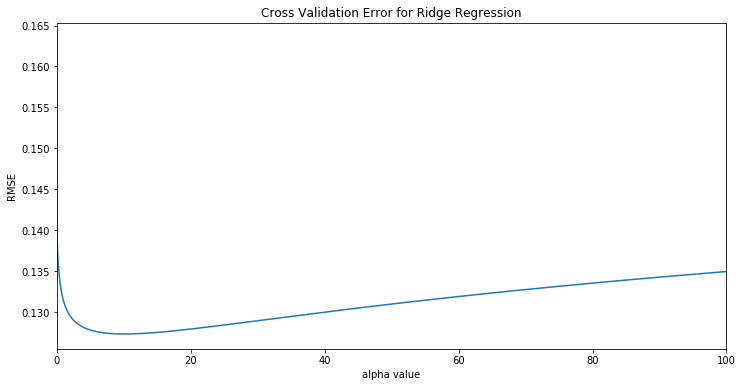

In [259]:
cv_ridge_rmse = pd.Series(cv_ridge_rmse, index = alphas)
cv_ridge_rmse.plot(title = "Cross Validation Error for Ridge Regression")
plt.xlabel("alpha value")
plt.xlim(0,100)
plt.ylabel("RMSE")

In [245]:
min_rmse_ridge = cv_ridge_rmse.min()
best_alpha_ridge = cv_ridge_rmse[cv_ridge_rmse==min_rmse_ridge].index[0]
print("The lowest cross validation RMSE for Ridge Regression is {} when alpha={}".format(min_rmse_ridge,best_alpha_ridge))

The lowest cross validation RMSE for Ridge Regression is 0.12733847319204644 when alpha=9.771241535346501


#### Lasso regression

(-0.5, 0.5)

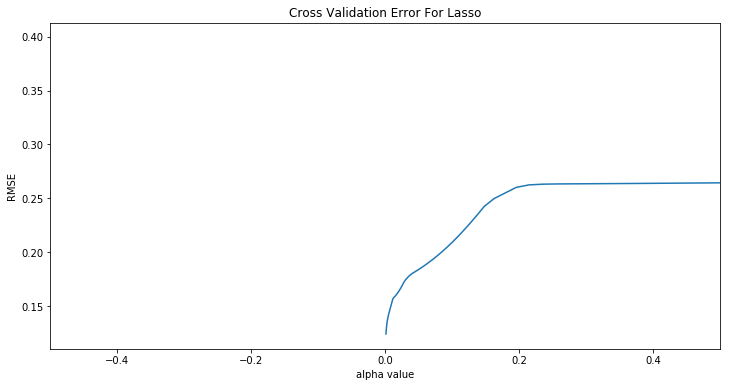

In [282]:
# the alphas in lasso are inverted from ridge
inv_alphas = np.ones(len(alphas)) /np.array(alphas)
cv_lasso_rmse = [rmse_cv(Lasso(alpha = alpha),X_train,y).mean() 
            for alpha in inv_alphas]
cv_lasso_rmse = pd.Series(cv_lasso_rmse, index = inv_alphas)
cv_lasso_rmse.plot(title = "Cross Validation Error For Lasso")
plt.xlabel("alpha value")
plt.ylabel("RMSE")
plt.xlim(-.5,.5)

In [263]:
min_rmse_lasso = cv_lasso_rmse.min()
best_alpha_lasso = cv_lasso_rmse[cv_lasso_rmse==min_rmse_lasso].index[0]
print("The lowest cross validation RMSE for Ridge Regression is {} when alpha={}".format(min_rmse_lasso,best_alpha_lasso))

The lowest cross validation RMSE for Ridge Regression is 0.12419498942266956 when alpha=0.001


In [289]:
# Create predictions with the best alpha scores for lasso and ridge
best_ridge = Ridge(alpha=best_alpha_ridge).fit(X_train,y)
best_lasso = Lasso(alpha=best_alpha_lasso).fit(X_train,y)

In [323]:
# exponentiate the prediction since we took the log of the sale price in the training data
y_pred_ridge = np.expm1(best_ridge.predict(X_test))
y_pred_lasso = np.expm1(best_lasso.predict(X_test))
ids = test['Id']

In [324]:
def print_predictions(filename,ids,y_pred):
    f = open(filename,'w')
    numRows = len(ids)
    # TODO: Print header
    for i in range(numRows):
        idNum = ids[i]
        y = y_pred[i]
        f.write("{},{}".format(idNum,y))
    f.close()

In [327]:
print_predictions("ridge_prediction.csv",ids,y_pred_ridge)
print_predictions("lasso_prediction.csv",ids,y_pred_lasso)

My lasso submission scored 0.12238.  
My ridge regression scored 0.12225.

### Question 4
Plot the $l_0$ norm (number of nonzeros) of the coefficients that lasso produces as you vary the
strength of regularization parameter alpha.

In [272]:
l0_norm = np.zeros(len(inv_alphas))
for i in range(len(inv_alphas)):
    alpha = inv_alphas[i]
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train,y)
    coeff = lasso_model.coef_
    num_nzero_coeff = sum(coeff != 0)
    l0_norm[i] = num_nzero_coeff


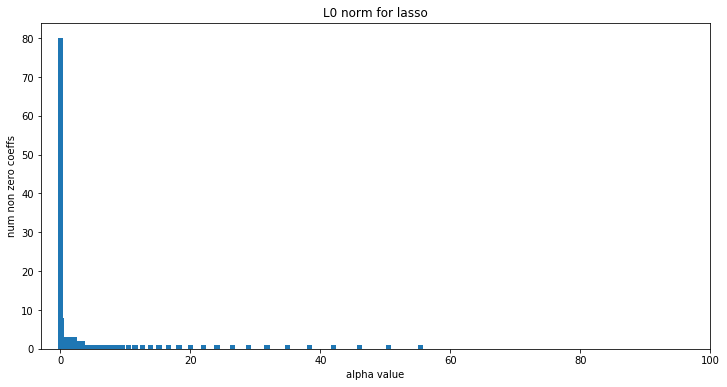

In [285]:
plt.bar(inv_alphas,l0_norm)
plt.xlim(-3,100)
plt.title("L0 norm for lasso")
plt.xlabel('alpha value')
plt.ylabel('num non zero coeffs')
plt.show()